In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
import sys
sys.path.append("./src/models/")
sys.path.append("./src/")
import utils as utils
from torch.utils.data import DataLoader
from MWU_CNN import MW_Unet
from tqdm import tqdm
import torchvision
import matplotlib.pyplot as plt

In [2]:
def imshow(img):
#     print('Image device and mean')
#     print(img.device)
#     print(img.mean())
    output_image = img.cpu().numpy().transpose((1,2,0))
    npimg = output_image.astype(np.uint8)
#     print('Mean of image: {}'.format(npimg.mean()))
    #format H,W,C
    plt.imshow(npimg)
    plt.show()
def save_image(img, path):
#     img = img * 0.5 + 0.5
    torchvision.utils.save_image(img, path)
    
def backprop(optimizer,model_output,target):
    optimizer.zero_grad()
    loss_fn = nn.MSELoss()
    loss = loss_fn(model_output,target)
    loss.backward()
    optimizer.step()
    return loss
def get_PSNR(model_output,target):
    I_hat = model_output.cpu().detach().numpy()
    I = target.cpu().detach().numpy()
    mse = (np.square(I-I_hat)).mean(axis=None)
    PSNR = 10 * np.log10(1.0/mse)
    return PSNR
def train(args):
    """
    train model
    """
    
    ####################################### Initializing Model #######################################
    
    step = 0.01
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print_every = int(args['--print_every'])
    num_epochs = int(args['--num_epochs'])
    save_every = int(args['--save_every'])
    save_path = str(args['--model_save_path'])
    batch_size = int(args['--batch_size'])
    train_data_path = args['--data_path']
    n  = int(args['--n'])
    train_split,val_split = args['--train_split'],args['--val_split']
    
    img_directory = args['--train_img_directory']

    model = MW_Unet(num_conv=3,in_ch=1)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=step)
    
    ######################################### Loading Data ##########################################
    dataset_total = utils.patchesDataset(patches_path=train_data_path,n=n)
    
    train_max_idx = int(train_split*len(dataset_total))
#     print(train_max_idx)
    dataset_train = torch.utils.data.Subset(dataset_total,range(0,train_max_idx))
    val_max_idx = train_max_idx+int(val_split*len(dataset_total))
    dataset_val = torch.utils.data.Subset(dataset_total,range(train_max_idx,val_max_idx))
#     print(test_max_idx)
    
#     dataset_test = torch.utils.data.Subset(dataset_total,range(val_max_idx,test_max_idx))
    
    dataloader_train = DataLoader(dataset_train,batch_size=batch_size)
    dataloader_val = DataLoader(dataset_val,batch_size=batch_size)
    
    
    print("length of train set: ",len(dataset_train))
    print("length of val set: ",len(dataset_val))
#     print("length of test set: ",len(dataset_test))
    
    train_PSNRs = []
    train_losses = []
    val_PSNRs = []
    val_losses = []
    init_epoch = 0 
    
    best_val_PSNR = 0.0
    try:
        for epoch in range(1, num_epochs + 1):
                #INITIATE dataloader_train
                print("epoch: ",epoch)
                with tqdm(total = len(dataloader_train)) as pbar:
                    for index, sample in enumerate(dataloader_train):

                        model.train()

                        target,model_input = sample['target'],sample['input']
                        target = target.to(device)
                        model_input = model_input.to(device)

                        output = model.forward(model_input)

                        train_loss = backprop(optimizer,output,target)

                        train_PSNR = get_PSNR(output,target)

                        avg_val_PSNR = []
                        avg_val_loss = []
                        model.eval()
                        with torch.no_grad():
                            for val_index,sample in enumerate(dataloader_val):
                                target,model_input = sample['target'],sample['input']
                                
                                target = target.to(device)
                                model_input = model_input.to(device)
                                
                                output = model.forward(model_input)
                                loss_fn = nn.MSELoss()
                                loss_val = loss_fn(output,target)
                                PSNR = get_PSNR(output,target)
                                avg_val_PSNR.append(PSNR)
                                avg_val_loss.append(loss_val.cpu().detach().numpy())
                        avg_val_PSNR = np.mean(avg_val_PSNR)
                        avg_val_loss = np.mean(avg_val_loss)
                        val_PSNRs.append(avg_val_PSNR)
                        val_losses.append(avg_val_loss)

                        train_losses.append(train_loss.cpu().detach().numpy())
                        train_PSNRs.append(train_PSNR)

                        if index == len(dataloader_train) - 1:
                            img_grid = output.data
                            img_grid = torchvision.utils.make_grid(img_grid)
                            real_grid = target.data
                            real_grid = torchvision.utils.make_grid(real_grid)
                            directory = img_directory
                            input_grid = model_input.data
                            input_grid = torchvision.utils.make_grid(input_grid)
                            save_image(input_grid,'{}train_input_img.png'.format(directory))
                            save_image(img_grid,'{}train_img_{}.png'.format(directory,epoch))
                            save_image(real_grid,'{}train_real_img_{}.png'.format(directory,epoch))
                            print('train images')
                            imshow(input_grid)
                            imshow(img_grid)
                            imshow(real_grid)
                            
                        pbar.update(1)
                    if epoch % print_every == 0: 
                        print ("Epoch: {}, Loss: {}, Training PSNR: {}".format(epoch, train_loss, train_PSNR))
                        print ("Epoch: {}, Avg Val Loss: {},Avg Val PSNR: {}".format(epoch, avg_val_loss, avg_val_PSNR))
                    if epoch % save_every == 0 and best_val_PSNR < avg_val_PSNR:
                        best_val_PSNR = avg_val_PSNR
                        print("new best Avg Val PSNR: {}".format(best_val_PSNR))
                        print ("Saving model to {}".format(save_path))
                        torch.save({'epoch': epoch,
                            'model_state_dict': model.state_dict(), 
                            'optimizer_state_dict': optimizer.state_dict(), 
                            'loss': train_loss}, 
                             save_path)
                        print ("Saved successfully to {}".format(save_path))
                        
                        
    except KeyboardInterrupt:
        print("Training interupted...")
        print ("Saving model to {}".format(save_path))
        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(), 
                    'optimizer_state_dict': optimizer.state_dict(), 
                    'loss': train_loss}, 
                     save_path)
        print ("Saved successfully to {}".format(save_path))          
        

    print("Training completed.")
    
    return (train_losses,train_PSNRs,val_losses,val_PSNRs,best_val_PSNR)

def Test(args):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print_every = int(args['--print_every'])
    num_epochs = int(args['--num_epochs'])
    save_every = int(args['--save_every'])
    batch_size = int(args['--batch_size'])
    n  = int(args['--n'])
    train_split,val_split,test_split = args['--train_split'],args['--val_split'],args['--test_split']
    data_path = args['--data_path']
    model_path = args['--model_save_path']
    img_directory = args['--test_img_directory']
    ################################ Load Data ###################################################
    dataset_total = utils.patchesDataset(patches_path=data_path,n=n)
    train_max_idx = int(train_split*len(dataset_total))
    val_max_idx = train_max_idx+int(val_split*len(dataset_total))
    test_max_idx = val_max_idx + int(test_split*len(dataset_total))
    dataset_test = torch.utils.data.Subset(dataset_total,range(val_max_idx,test_max_idx))
    dataloader_test = DataLoader(dataset_test, batch_size = batch_size)
    
#     print(len(dataset_test))
    load_path = model_path
    
    model = MW_Unet(num_conv=3,in_ch=1)
    model.to(device)
    
    if(load_path != None):
        print("Loading model from {}".format(load_path))
        checkpoint = torch.load(load_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #epoch = checkpoint['epoch']
        print("Model successfully loaded from {}".format(load_path))
    
    model.eval()
    
    print("Testing...")
    
    test_loss = []
    test_PSNR = []
    
    with tqdm(total=len(dataloader_test)) as pbar:
        with torch.no_grad():
            for index, sample in enumerate(dataloader_test):
                target,model_input = sample['target'],sample['input']
                target = target.to(device)
                model_input = model_input.to(device)

                output = model.forward(model_input)
                
                loss_fn = nn.MSELoss()

                loss = loss_fn(output,target)
                PSNR = get_PSNR(output,target)
                
                test_loss.append(loss.cpu().numpy())
                test_PSNR.append(PSNR)
                
                if index == len(dataloader_test) - 1:
                    img_grid = output.data
                    img_grid = torchvision.utils.make_grid(img_grid)
                    directory = img_directory
                    save_image(img_grid,'{}test_img.png'.format(directory))
                    input_grid = model_input.data
                    input_grid = torchvision.utils.make_grid(input_grid)
                    save_image(input_grid,'{}test_input_img.png'.format(directory))
                    real_grid = target.data
                    real_grid = torchvision.utils.make_grid(real_grid)
                    save_image(real_grid,'{}test_real_img.png'.format(directory))
                    print('test images')
                    imshow(input_grid)
                    imshow(img_grid)
                    imshow(real_grid)
                pbar.update(1)
                
                
    test_loss,test_PSNR = np.mean(np.array(test_loss)), np.mean(np.array(test_PSNR))
    
    str_to_save = "Test_loss: " + str(test_loss) + " , Test PSNR: " + str(test_PSNR)
    
    with open("test_results.txt",'a') as test_writer:
        test_writer.write(str_to_save + "\n")
    
    return (test_loss,test_PSNR)


            
        
            

                    
                            
                            
                            
                            
                    
                    
                    

    
    
    
    


channel_1: 16, channel_2: 32


  0%|          | 0/24000 [00:00<?, ?it/s]

loading patches from patches directory


100%|██████████| 24000/24000 [00:35<00:00, 668.00it/s]


completed loading patches from directory!
(24000, 240, 240)


  0%|          | 0/300 [00:00<?, ?it/s]

shape of target: (24000, 1, 240, 240) shape of noisy: (24000, 1, 240, 240)
length of train set:  19200
length of val set:  2400
epoch:  1


100%|█████████▉| 299/300 [25:29<00:05,  5.38s/it]

train images


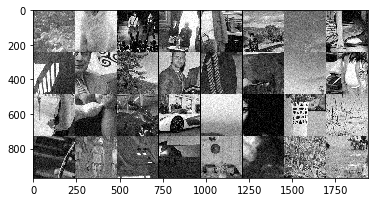

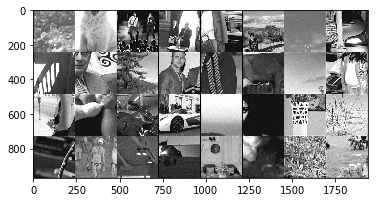

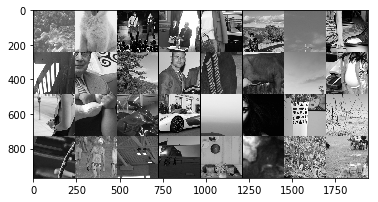

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.00426112487912178, Training PSNR: 23.704758328349072
Epoch: 1, Avg Val Loss: 0.0036248203832656145,Avg Val PSNR: 24.415529853854455
new best Avg Val PSNR: 24.415529853854455
Saving model to ./experiments/baseline/baseline.pt
Saved successfully to ./experiments/baseline/baseline.pt
epoch:  2


100%|█████████▉| 299/300 [26:07<00:04,  4.75s/it]

train images


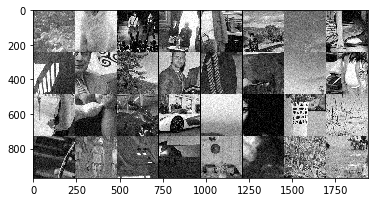

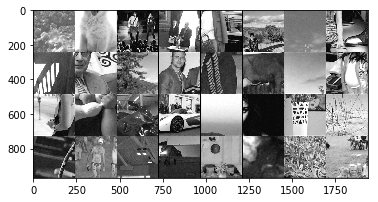

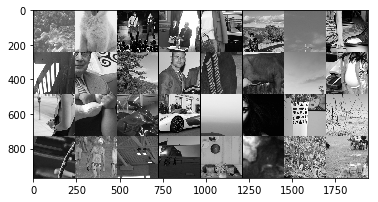

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.0036092030350118876, Training PSNR: 24.425886580855657
Epoch: 2, Avg Val Loss: 0.002986850682646036,Avg Val PSNR: 25.25893123954908
new best Avg Val PSNR: 25.25893123954908
Saving model to ./experiments/baseline/baseline.pt
Saved successfully to ./experiments/baseline/baseline.pt
epoch:  3


100%|█████████▉| 299/300 [23:47<00:04,  4.77s/it]

train images


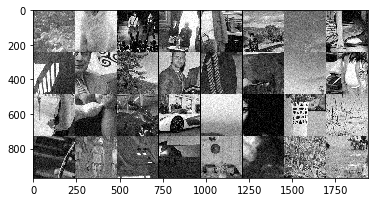

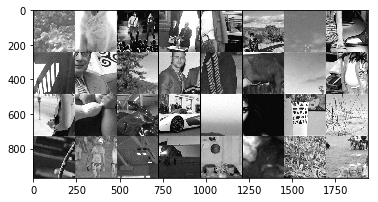

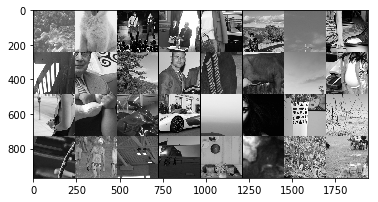

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.0034299392718821764, Training PSNR: 24.64713421801474
Epoch: 3, Avg Val Loss: 0.0026857994962483644,Avg Val PSNR: 25.71946994366739
new best Avg Val PSNR: 25.71946994366739
Saving model to ./experiments/baseline/baseline.pt
Saved successfully to ./experiments/baseline/baseline.pt
epoch:  4


100%|█████████▉| 299/300 [23:51<00:04,  4.79s/it]

train images


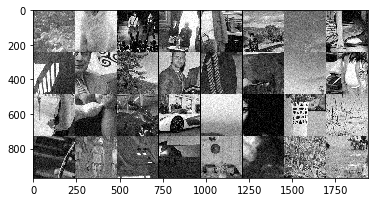

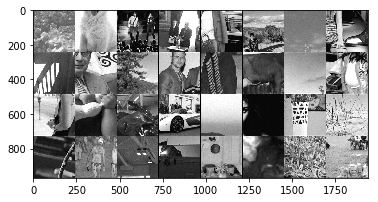

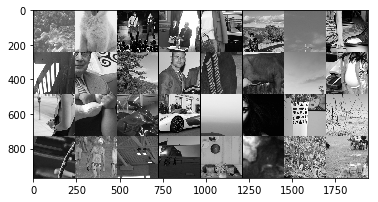

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.003384436247870326, Training PSNR: 24.705137219853505
Epoch: 4, Avg Val Loss: 0.0025875375140458345,Avg Val PSNR: 25.88008727617605
new best Avg Val PSNR: 25.88008727617605
Saving model to ./experiments/baseline/baseline.pt
Saved successfully to ./experiments/baseline/baseline.pt
epoch:  5


100%|█████████▉| 299/300 [23:52<00:04,  4.80s/it]

train images


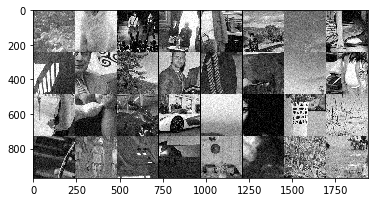

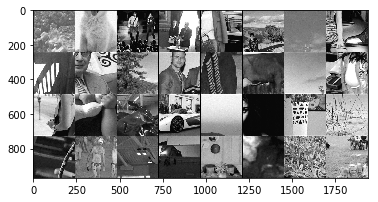

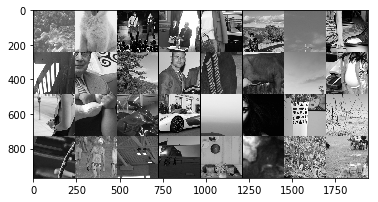

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.003358344780281186, Training PSNR: 24.738749303718425
Epoch: 5, Avg Val Loss: 0.0017789388075470924,Avg Val PSNR: 27.51414095002264
new best Avg Val PSNR: 27.51414095002264
Saving model to ./experiments/baseline/baseline.pt
Saved successfully to ./experiments/baseline/baseline.pt
epoch:  6


100%|█████████▉| 299/300 [23:53<00:04,  4.76s/it]

train images


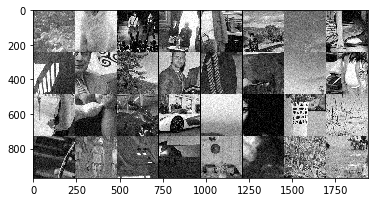

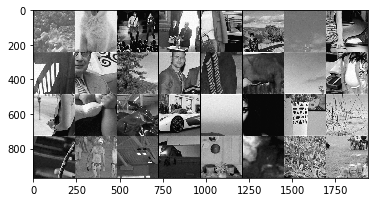

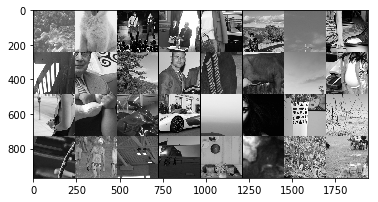

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.0033473449293524027, Training PSNR: 24.752995331767423
Epoch: 6, Avg Val Loss: 0.001641946379095316,Avg Val PSNR: 27.865708507491743
new best Avg Val PSNR: 27.865708507491743
Saving model to ./experiments/baseline/baseline.pt
Saved successfully to ./experiments/baseline/baseline.pt
epoch:  7


100%|█████████▉| 299/300 [23:47<00:04,  4.80s/it]

train images


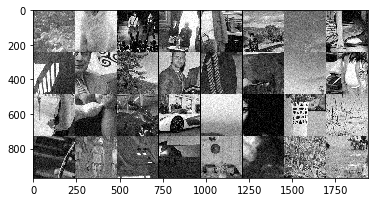

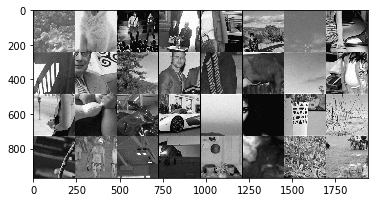

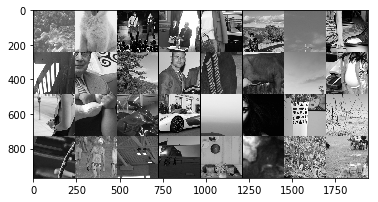

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.0033258625771850348, Training PSNR: 24.78095669151973
Epoch: 7, Avg Val Loss: 0.0015573074342682958,Avg Val PSNR: 28.09700560096005
new best Avg Val PSNR: 28.09700560096005
Saving model to ./experiments/baseline/baseline.pt
Saved successfully to ./experiments/baseline/baseline.pt
epoch:  8


100%|█████████▉| 299/300 [23:47<00:04,  4.77s/it]

train images


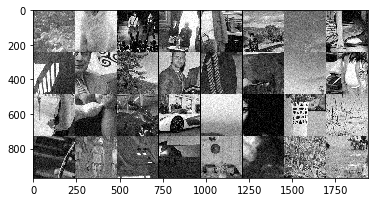

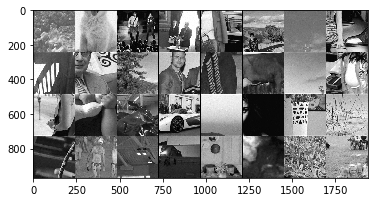

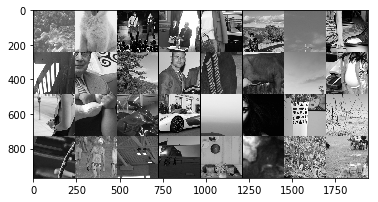

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.0033056605607271194, Training PSNR: 24.807415907326384
Epoch: 8, Avg Val Loss: 0.0015353934140875936,Avg Val PSNR: 28.157309402576917
new best Avg Val PSNR: 28.157309402576917
Saving model to ./experiments/baseline/baseline.pt
Saved successfully to ./experiments/baseline/baseline.pt
epoch:  9


100%|█████████▉| 299/300 [23:46<00:04,  4.77s/it]

train images


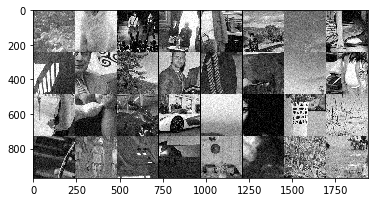

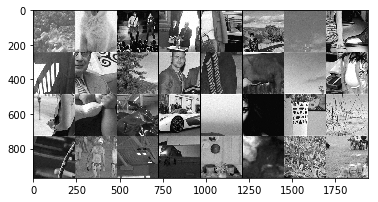

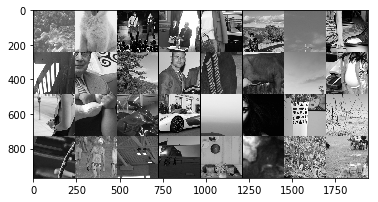

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.003278420539572835, Training PSNR: 24.84335091298172
Epoch: 9, Avg Val Loss: 0.001551631256006658,Avg Val PSNR: 28.11019217846153
epoch:  10


100%|█████████▉| 299/300 [23:46<00:04,  4.77s/it]

train images


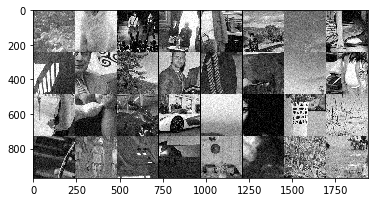

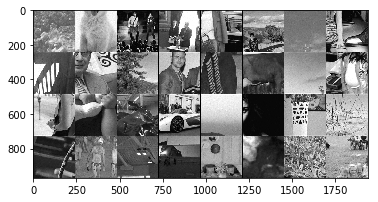

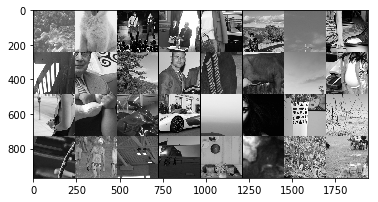

100%|██████████| 300/300 [23:53<00:00,  5.30s/it]


Epoch: 10, Loss: 0.0032351433765143156, Training PSNR: 24.901062172674276
Epoch: 10, Avg Val Loss: 0.0015911138616502285,Avg Val PSNR: 27.999442213353817
Training completed.


  0%|          | 0/24000 [00:00<?, ?it/s]

Final training loss: 0.0032351433765143156, Best Validation PSNR: 28.157309402576917
loading patches from patches directory


100%|██████████| 24000/24000 [00:33<00:00, 716.25it/s]


completed loading patches from directory!
(24000, 240, 240)


  3%|▎         | 1/38 [00:00<00:04,  7.87it/s]

shape of target: (24000, 1, 240, 240) shape of noisy: (24000, 1, 240, 240)
channel_1: 16, channel_2: 32
Loading model from ./experiments/baseline/baseline.pt
Model successfully loaded from ./experiments/baseline/baseline.pt
Testing...


 97%|█████████▋| 37/38 [00:04<00:00,  8.51it/s]

test images


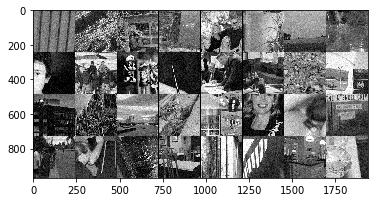

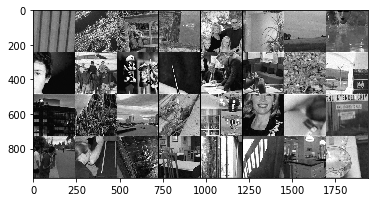

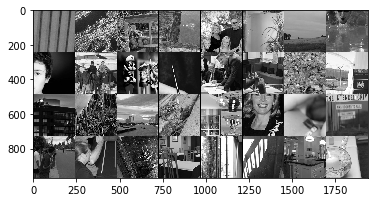

100%|██████████| 38/38 [00:06<00:00,  1.59it/s]


Test loss: 0.0015714028850197792, Test PSNR: 28.059542009550274


In [3]:
args = {'--print_every':1,
        '--num_epochs':10,
        '--save_every':1,
        '--data_path':'./data/patches/',
        '--batch_size':64,
        '--model_save_path': "./experiments/baseline/baseline.pt",
        '--n': 24000,
        '--test_split': 0.1,
        '--val_split':0.1,
        '--train_split':0.8,
        '--train_img_directory':'./experiments/images/train_images/',
        '--test_img_directory': './experiments/images/test_images/'
        }
train_losses,train_PSNRs,val_losses,val_PSNRs,best_val_PSNR = train(args)
np.save('train_PSNRs.npy', np.array(train_PSNRs))
np.save('train_losses.npy', np.array(train_losses))
np.save('val_PSNRs.npy', np.array(val_PSNRs))
np.save('val_losses.npy', np.array(val_losses))

loss = train_losses[-1]
print("Final training loss: {}, Best Validation PSNR: {}".format(loss, best_val_PSNR))

test_loss,test_PSNR = Test(args)
print("Test loss: {}, Test PSNR: {}".format(test_loss, test_PSNR))